In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%matplotlib inline

import seaborn as sns
sns.set_style("ticks")
sns.set_context(context='paper',font_scale=1.2)
sns.despine()

import yaml
import os
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings('ignore')

<Figure size 432x288 with 0 Axes>

In [13]:
tasks = ['hospital_mortality','LOS_7','readmission_30','icu_admission','aki1_label','aki2_label','hg_label','np_500_label','np_1000_label']
metrics = ['auc', 'auprc', 'ace_abs_logistic_logit']
model_path = '/local-scratch/nigam/projects/jlemmon/transfer_learning/experiments/artifacts/models'
results_path = '/local-scratch/nigam/projects/jlemmon/transfer_learning/experiments/artifacts/results'
old_results_path = '/local-scratch/nigam/projects/jlemmon/transfer_learning/experiments/artifacts/results_bkup'
figure_path = '/local-scratch/nigam/projects/jlemmon/transfer_learning/experiments/notebooks/figures'

models = ['lr']
feat_groups = ['shared', 'pediatric', 'adult']
cohort_types = ['pediatric', 'adult']

titles = {'hospital_mortality':'In-hospital\nMortality', 'LOS_7':'Length of Stay\n> 7 days', 'icu_admission':'Admission to\nICU', 'readmission_30':'Readmission\nafter 30 days', 'aki1_label':'Acute Kidney\nInjury 1','aki2_label':'Acute Kidney\nInjury 2','hg_label':'Hypoglycemia','np_500_label':'Neutropenia\n<500','np_1000_label':'Neutropenia\n<1000'}

In [22]:
y_axis = {
    'auc':{
        'lim':[0.5,1],
        'label':'AUROC'
    },
    'auprc':{
        'lim':[-0.1, 1],
        'label':'AUPRC'
    },
    'ace_abs_logistic_logit':{
        'lim':[-0.03, 0.18],
        'label':'Calibration'
    }
}

dot_shapes = {
    'shared':'o',
    'pediatric':'s',
    'adult':'D'
}

lr_dot_colours = {
    'pediatric':'black',
    'adult':'blue'
}

nlr_dot_colours = {
    'pediatric':'red',
    'adult':'green'
}

bg_colours = {
    'hospital_mortality':'lightgray', 
    'LOS_7':'red', 
    'icu_admission':'sienna', 
    'readmission_30':'orange', 
    'sudden_cardiac_death':'gold', 
    'aki1_label':'darkkhaki',
    'aki2_label':'chartreuse',
    'hg_label':'deepskyblue', 
    'np_500_label':'deeppink', 
    'np_1000_label':'purple'
}

In [23]:
# Get baseline model
old_lr_df = pd.DataFrame()
for ct in cohort_types:
    for task in tasks:
        for fg in feat_groups:
            df = pd.read_csv(f'{old_results_path}/{ct}/lr/{task}/{fg}_feats/best/test_eval.csv')
            df['task'] = task
            df['cohort'] = ct
            df['model'] = 'Exc. LR'
            df['feature_group'] = fg
            old_lr_df = pd.concat([old_lr_df,df])

new_lr_df = pd.DataFrame()
for ct in cohort_types:
    for task in tasks:
        for fg in feat_groups:
            df = pd.read_csv(f'{results_path}/{ct}/lr/{task}/{fg}_feats/best/test_eval.csv')
            df['task'] = task
            df['cohort'] = ct
            df['model'] = 'Inc. LR'
            df['feature_group'] = fg
            new_lr_df = pd.concat([new_lr_df,df])

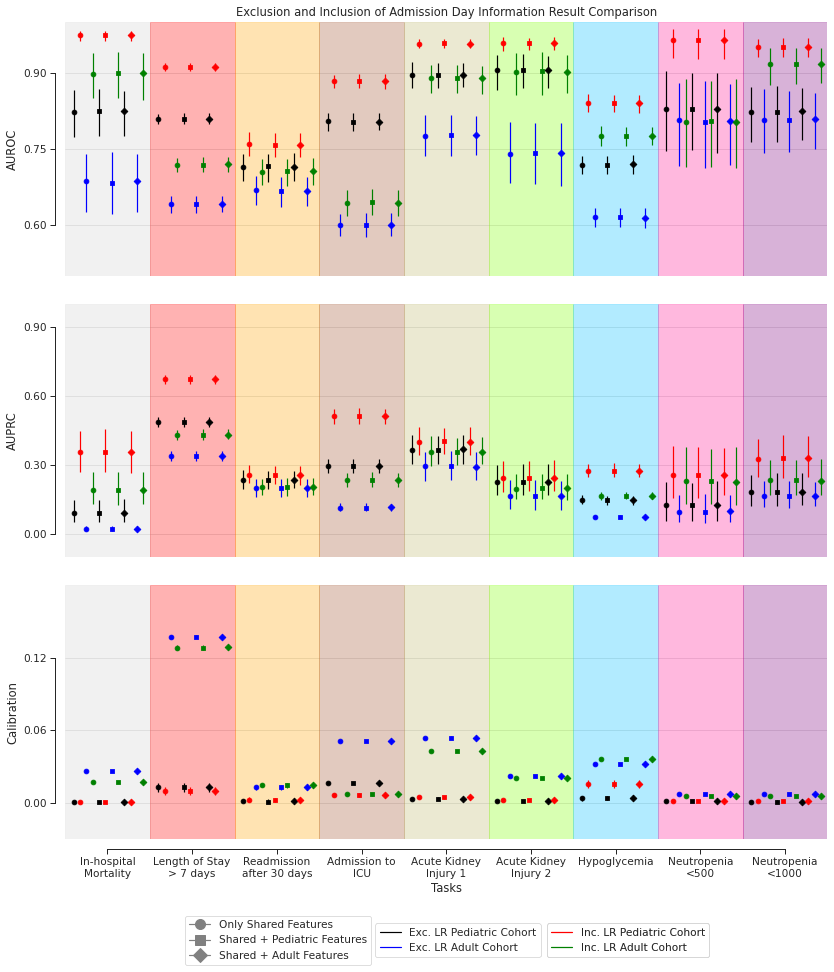

In [28]:
# For each task plot baseline vs CL
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(12,15))
plt.tight_layout(w_pad=1,h_pad=0.5,rect=[0.05,0.15,1,0.95])

for r, metric in enumerate(metrics):
    for c, task in enumerate(tasks):
        col_num = 0.6
        axes[r].axvspan(c+0.5, c+1.5,0,1,color=bg_colours[task], alpha=0.3)
        for fg in feat_groups:
            for ct in cohort_types:

                lr_evals = old_lr_df.query('task==@task and metric==@metric and feature_group==@fg and cohort==@ct')

                lr_evals['CI_upper'] = (lr_evals['CI_upper'] - lr_evals['CI_med']).abs()
                lr_evals['CI_lower'] = (lr_evals['CI_med'] - lr_evals['CI_lower']).abs()
            
                
                lr_line = axes[r].scatter(
                    c + col_num,
                    lr_evals['CI_med'],
                    marker = dot_shapes[fg],
                    color = lr_dot_colours[ct]
                )
                axes[r].errorbar(
                    c + col_num,
                    lr_evals['CI_med'],
                    lr_evals[['CI_lower', 'CI_upper']].values.T,
                    color = lr_dot_colours[ct]
                )
                
                nlr_evals = new_lr_df.query('task==@task and metric==@metric and feature_group==@fg and cohort==@ct')

                nlr_evals['CI_upper'] = (nlr_evals['CI_upper'] - nlr_evals['CI_med']).abs()
                nlr_evals['CI_lower'] = (nlr_evals['CI_med'] - nlr_evals['CI_lower']).abs()

                nlr_line = axes[r].scatter(
                    c + 0.075 + col_num,
                    nlr_evals['CI_med'],
                    marker = dot_shapes[fg],
                    color = sgd_dot_colours[ct]
                )
                axes[r].errorbar(
                    c + 0.075 + col_num,
                    nlr_evals['CI_med'],
                    nlr_evals[['CI_lower', 'CI_upper']].values.T,
                    color = nlr_dot_colours[ct]
                )
                
                col_num += 0.15

        plt.xticks(np.arange(1,len(tasks)+1,1))
        axes[r].set_ylim(y_axis[metric]['lim'])
        axes[r].set_xlim([0.5,len(tasks)+0.5])
        axes[r].yaxis.set_major_locator(MaxNLocator(nbins=4,prune='both'))
        axes[r].grid(which='major', linewidth=0.5, axis='y')
        if r == 0:
            axes[r].set_title('Exclusion and Inclusion of Admission Day Information Result Comparison')
        if r == len(metrics) - 1:
            axes[r].set_xlabel('Tasks')
            axes[r].set_xticklabels(labels=[titles[t] for t in tasks])
        else:
            axes[r].set_xticklabels('')
            axes[r].set_xlabel('')
            axes[r].spines['bottom'].set_color('white')
            axes[r].tick_params(axis='x', length=0)  
        axes[r].set_ylabel(y_axis[metric]['label'])
        axes[r].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

shape_leg = [Line2D([0],[0], color='grey', marker='o', markersize=10),
                Line2D([0],[0], color='grey', marker='s', markersize=10),
                Line2D([0],[0], color='grey', marker='D', markersize=10)] 
shape_leg_lbls = ['Only Shared Features', 'Shared + Pediatric Features', 'Shared + Adult Features']
shape_legend = plt.legend(shape_leg, shape_leg_lbls, bbox_to_anchor=(0.15,-0.45,0.1,0.1), loc="center left")
plt.gca().add_artist(shape_legend)

lr_leg = [Line2D([0],[0], color='black'),
                Line2D([0],[0], color='blue')] 
lr_leg_lbls = ['Exc. LR Pediatric Cohort', 'Exc. LR Adult Cohort']
lr_legend = plt.legend(lr_leg, lr_leg_lbls, bbox_to_anchor=(0.4,-0.45,0.1,0.1), loc="center left")
plt.gca().add_artist(lr_legend)

nlr_leg = [Line2D([0],[0], color='red'),
                Line2D([0],[0], color='green')] 
nlr_leg_lbls = ['Inc. LR Pediatric Cohort', 'Inc. LR Adult Cohort']
nlr_legend = plt.legend(nlr_leg, nlr_leg_lbls, bbox_to_anchor=(0.625,-0.45,0.1,0.1), loc="center left")
plt.gca().add_artist(nlr_legend)

sns.despine(offset=10, trim=True,)


plt.savefig('figures/lr_comp_bl.png', bbox_inches='tight')
plt.show()
